In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define constants 
NTT_PATH = "./data/ntt_data"
COVID_PATH = "./data/covid_data"
WEATHER_PATH = "./data/weather"

In [4]:
# load shinagawa station data 
tokyo_df = pd.read_csv(f"{NTT_PATH}/shibs_sample.csv")



In [8]:
# load shibuya station data
shibuya_cov_df = pd.read_csv(f"{NTT_PATH}/shibuya_daily_pop_covid.csv")
shibuya_cov_df.head()
shibuya_cov_df.columns

Index(['date', 'daily_avg_population', 'total_new_cases', 'tokyo_new_cases',
       'total_weekly_diff', 'tokyo_weekly_diff', 'total_severe_cases',
       'tokyo_severe_cases', 'total_cum_deaths', 'tokyo_cum_deaths',
       'total_daily_deaths', 'tokyo_daily_deaths', 'soe1', 'soe2', 'soe3',
       'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4',
       'wave5'],
      dtype='object')

In [6]:
# xgboost on dataset 
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# prepare data for XGBoost

# set date as index
shibuya_cov_df.set_index('date', inplace=True)

# select the columns to use as features and target
features = shibuya_cov_df.drop(['daily_avg_population'], axis=1)
target = shibuya_cov_df['daily_avg_population']

# split data into training and test sets
train_size = int(len(shibuya_cov_df) * 0.7)
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# set XGBoost parameters
params = {'objective': 'reg:squarederror',
          'eval_metric': 'rmse',
          'seed': 0}

# train XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# make predictions on test data
predictions = model.predict(dtest)

# evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')


RMSE: 20994.914596596256


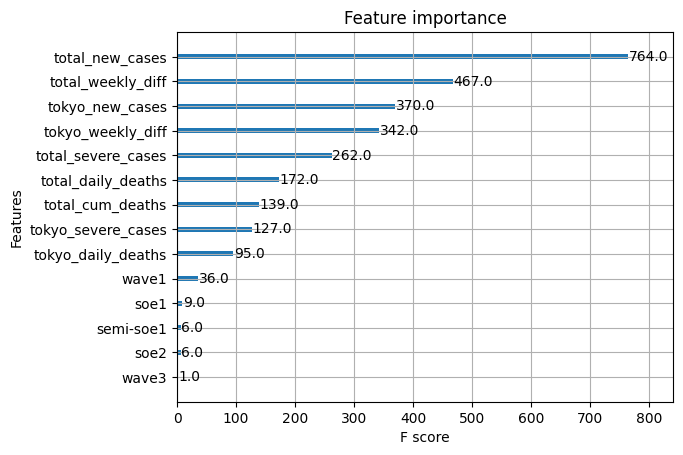

In [7]:
# plot feature importance
xgb.plot_importance(model)

# show plot
plt.show()

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# create lag variables
shibuya_cov_df['total_new_cases_lag'] = shibuya_cov_df['total_new_cases'].shift(1)
shibuya_cov_df['tokyo_new_cases_lag'] = shibuya_cov_df['tokyo_new_cases'].shift(1)
shibuya_cov_df['total_weekly_diff_lag'] = shibuya_cov_df['total_weekly_diff'].shift(1)
shibuya_cov_df['tokyo_weekly_diff_lag'] = shibuya_cov_df['tokyo_weekly_diff'].shift(1)
shibuya_cov_df['total_severe_cases_lag'] = shibuya_cov_df['total_severe_cases'].shift(1)
shibuya_cov_df['tokyo_severe_cases_lag'] = shibuya_cov_df['tokyo_severe_cases'].shift(1)
shibuya_cov_df['total_cum_deaths_lag'] = shibuya_cov_df['total_cum_deaths'].shift(1)
shibuya_cov_df['tokyo_cum_deaths_lag'] = shibuya_cov_df['tokyo_cum_deaths'].shift(1)
shibuya_cov_df['total_daily_deaths_lag'] = shibuya_cov_df['total_daily_deaths'].shift(1)
shibuya_cov_df['tokyo_daily_deaths_lag'] = shibuya_cov_df['tokyo_daily_deaths'].shift(1)

# prepare data for linear regression
reg_df = shibuya_cov_df[[
    'daily_avg_population',
    'total_new_cases_lag',
    'tokyo_new_cases_lag',
    'total_weekly_diff_lag',
    'tokyo_weekly_diff_lag',
    # 'total_severe_cases_lag',
    # 'tokyo_severe_cases_lag',
    # 'total_cum_deaths_lag',
    # 'tokyo_cum_deaths_lag',
    # 'total_daily_deaths_lag',
    # 'tokyo_daily_deaths_lag',
    'soe1', 
    'soe2', 
    'soe3',
    'soe4', 
    'semi-soe1', 
    'semi-soe2', 
    'wave1', 
    'wave2', 
    'wave3', 
    'wave4',
    'wave5']]

reg_df.dropna(axis=0, inplace=True)

# select the columns to use as features and target
X = reg_df[['total_new_cases_lag',
            'tokyo_new_cases_lag',
            'total_weekly_diff_lag',
            'tokyo_weekly_diff_lag',
            # 'total_severe_cases_lag',
            # 'tokyo_severe_cases_lag',
            # 'total_cum_deaths_lag',
            # 'tokyo_cum_deaths_lag',
            # 'total_daily_deaths_lag',
            # 'tokyo_daily_deaths_lag',
            'soe1', 
            'soe2', 
            'soe3',
            'soe4', 
            'semi-soe1', 
            'semi-soe2', 
            'wave1', 
            'wave2', 
            'wave3', 
            'wave4',
            'wave5']]

y = reg_df['daily_avg_population']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# train linear regression model
reg = LinearRegression().fit(X_train, y_train)

# make predictions on test data
y_pred = reg.predict(X_test)

# evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}, R2: {r2}')


RMSE: 16952.57117688206, R2: 0.3511610536216818


/var/folders/00/2zkqvc3n5y37rp1f1p9qc_5r0000gn/T/ipykernel_3792/3293546190.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df.dropna(axis=0, inplace=True)


In [24]:
import statsmodels.api as sm

# add constant to the model
X_train = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

                                  OLS Regression Results                                 
Dep. Variable:     daily_avg_population   R-squared (uncentered):                   0.955
Model:                              OLS   Adj. R-squared (uncentered):              0.955
Method:                   Least Squares   F-statistic:                              1001.
Date:                  Tue, 17 Jan 2023   Prob (F-statistic):                        0.00
Time:                          12:45:15   Log-Likelihood:                         -8229.1
No. Observations:                   715   AIC:                                  1.649e+04
Df Residuals:                       700   BIC:                                  1.656e+04
Df Model:                            15                                                  
Covariance Type:              nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
----------